# LFD Homework 8
 
Eighth week homework for the "Learning from Data" course offerd by [Caltech on edX](https://courses.edx.org/courses/course-v1:CaltechX+CS1156x+3T2017). Note that this notebook does not contain *all* solutions; it showcases solutions to those problems that require programming / simulation (and omits pen and paper problems).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn import svm

%matplotlib notebook

## SVM with Soft Margins

First, we are going to load the data. There are two data sets available for this homework

 * [Training Set](http://www.amlbook.com/data/zip/features.train)
 * [Test Set](http://www.amlbook.com/data/zip/features.test)

The data format for each line is: `digit intensity symmetry`. Here we can adapt the code for loading data automatically from the last homeworks:

In [2]:
def load_data(urls=[
        'http://www.amlbook.com/data/zip/features.train',
        'http://www.amlbook.com/data/zip/features.test'
    ]):
    '''Loads the data directly from the AML books website.'''
    
    r = requests.get(urls[0]); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    Y, X = np.split(data,[1], axis=-1)
    
    r = requests.get(urls[1]); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    Y_t, X_t = np.split(data,[1], axis=-1)
    
    return X, Y, X_t, Y_t

In order to make the data available in the following, we run then:

In [3]:
X, Y, X_t, Y_t = load_data()

The next step is to set up our SVM learning approach. For Soft Margin SVMs we can solve the dual formulation of the Lagrangian in order to obtain the $\alpha$ values. That is we solve the following constrained optimization problem:

$$
\begin{array}{rl}
\min_{\alpha} & \mathcal{L}(\alpha) = \frac{1}{2} \alpha^\intercal \mathbf{Q} \alpha + \left(-\mathbf{1}^\intercal\right) \alpha \\
\mathrm{s.t.} & \mathbf{Y}^\intercal\alpha = \mathbf{0} \\
& \mathbf{0} \leq \alpha \leq C~\mathbf{1}
\end{array}
$$

where  $\mathbf{Q} = \left(\mathbf{Y}\mathbf{Y}^\intercal \odot \mathbf{X}\mathbf{X}^\intercal\right)$ (here $\odot$ is the Hadamard product). The most productive route for implementation of subsequent experiments is the `libsvm` based SVM implementation of `scikit-learn`. The type of classification problems we are addressing here is solved using the `SVC` (Support Vector Classifier) class. This class is wrapped as:

In [4]:
class SVMClassifier:
    '''Soft margin SVM based binary classifier.'''
  
    def __init__(self, X, Y, C = .01, Q = 2):       
        self._h = svm.SVC(
            C = C,
            kernel='poly',
            gamma=1.,
            degree=Q, 
            coef0=1.
        ).fit(X, Y.ravel())
        self.E_in = self.E(X, Y)
        self.sv_count = np.sum(self._h.n_support_)
  
    def __call__(self, X):
        Y_hat = self._h.predict(X).reshape(-1,1)
        return Y_hat
  
    def E(self, X, Y):
        N, d = X.shape
        E = np.sum(Y != self(X)) / float(N)
        return E
    
    def n_sv(self):
        return np.sum(self._h.n_support_)

The two main schemes for multi-class classification in the following problems are the one-vs-all and one-vs-one schemes:

In [5]:
def one_vs_all(label, X, Y, C=.01, Q=2):
    ''' Trains one class label against all other class labels using 
    a Soft Margin SVM with polynomial kernel.'''
    
    N, d = X.shape
    Y_prime = (Y == label) * 2. - 1.
    g = SVMClassifier(X, Y_prime, C=C, Q=Q)
    return g


def one_vs_one(label, other_label, X, Y, C=.01, Q=2):
    ''' Trains one class label agains another using a Soft Margin SVM with
    polynomial kernel.'''
    
    idx = ((Y == label) | (Y == other_label)).ravel()
    X_prime, Y_prime = X[idx], Y[idx]
    Y_prime = (Y_prime == label) * 2. - 1.
    g = SVMClassifier(X_prime, Y_prime, C=C, Q=Q)
    return g

## Polynomial Kernels (P2 - P6)

Consider the polynomial kernel $K(x_n, x_m) = \left(1 + x_n^\intercal x_m\right)^Q$ where $Q$ is the degree of the polynomial.

### P2

With $C = 0.01$ and $Q = 2$, which of the following classifiers has the highest $E_{in}$? (one-vs-all)

In [6]:
G = [one_vs_all(i, X, Y) for i in range(0,10,2)]
E_in = np.array([g.E_in for g in G])

idx = np.argmax(E_in)
print('Maximum E_in\n'+ '-'*12 +'\n[{}] {} versus all'.format(
    'abcde'[idx],
    int(idx) * 2
))

Maximum E_in
------------
[a] 0 versus all


### P3

With $C = 0.01$ and $Q = 2$, which of the following classifiers has the lowest $E_{in}$? (one-vs-all)

In [7]:
G = [one_vs_all(i, X, Y) for i in range(1,11,2)]
E_in = np.array([g.E_in for g in G])

idx = np.argmin(E_in)
print('Minimum E_in\n'+ '-'*12 +'\n[{}] {} versus all'.format(
    'abcde'[idx], 
    int(idx) * 2 + 1
))

Minimum E_in
------------
[a] 1 versus all


### P4

Comparing the two selected classifiers from problems 2 and 3, which of the following values is closest to the difference between the number of support vectors of these classifiers?

In [8]:
g_E_in_max, g_E_in_min = [one_vs_all(i, X, Y) for i in (0, 1)]
delta = g_E_in_max.n_sv() - g_E_in_min.n_sv()

idx = np.argmin(np.abs(np.arange(1, 6) * 600 - delta))
print('Closest Difference\n'+ '-'*18 +'\n[{}] {}'.format(
    'abcde'[idx],
    (int(idx) + 1) * 600
))

Closest Difference
------------------
[c] 1800


### P5

Consider the 1-versus-5 classifier with $Q=2$ and $C \in \{0.001, 0.01, 0.1, 1\}$. Which of the following statements is correct? Going up or down means strictly so. 

First, we need a way to measure $E_{out}$ in the one-vs-one setting:

In [9]:
def E_ovo(label, other_label, G, X, Y):
    idx = ((Y == label) | (Y == other_label)).ravel()
    assert np.any(idx)
    
    X_prime, Y_prime = X[idx], Y[idx]
    Y_prime = (Y_prime == label) * 2. - 1.
    return np.array([g.E(X_prime, Y_prime) for g in G])

Now we can perform the experiment as:

In [10]:
C = 10.**np.arange(-3, 1)
G = [one_vs_one(1, 5, X, Y, C=c) for c in C]
N_sv = np.array([g.n_sv() for g in G])
E_in = np.array([g.E_in for g in G])
E_out = E_ovo(1, 5, G, X_t, Y_t)

print('Results\n-------')
for i, c in enumerate(C):
    print('C={}\tE_in={:.5f}\tE_out={:.5f}\t#SV={}'.format(c, E_in[i], E_out[i], N_sv[i]))

Results
-------
C=0.001	E_in=0.00448	E_out=0.01651	#SV=76
C=0.01	E_in=0.00448	E_out=0.01887	#SV=34
C=0.1	E_in=0.00448	E_out=0.01887	#SV=24
C=1.0	E_in=0.00320	E_out=0.01887	#SV=24


Visualizing helps to see the trends:

<IPython.core.display.Javascript object>


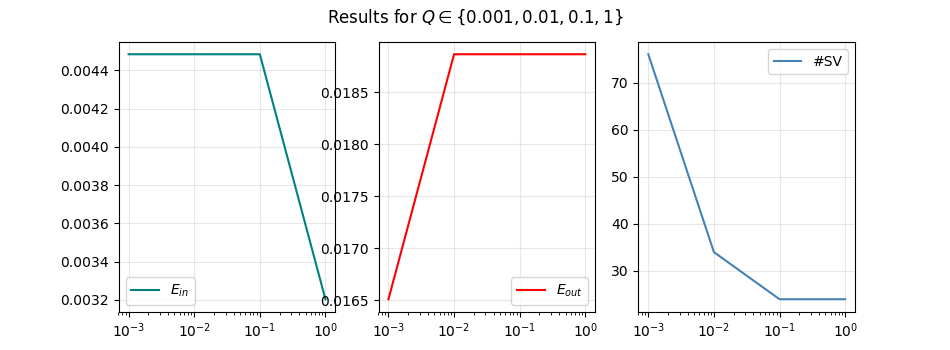

In [11]:
# plot the results
fix, ax = plt.subplots(1, 3, sharex=True, figsize=(9.5, 3.5))
plt.suptitle('Results for $Q \\in \\{0.001, 0.01, 0.1, 1\\}$')

ax[0].semilogx(C, E_in, color='teal', label='$E_{in}$')
ax[0].grid(alpha=.3); ax[0].legend(loc=3)

ax[1].semilogx(C, E_out, color='red', label='$E_{out}$')
ax[1].grid(alpha=.3); ax[1].legend()

ax[2].semilogx(C, N_sv, color='steelblue', label='#SV')
ax[2].grid(alpha=.3); ax[2].legend();

### P6

In the 1-versus-5 classifier, comparing $Q=2$ with $Q=5$, which of the following statements is correct?

In [12]:
g_Q2, g_Q5 = [one_vs_one(1,5, X, Y, C=1e-4, Q=Q) for Q in (2,5)]
print('When C = 0.0001, E_in is higher at Q=5: {}'.format(
    g_Q5.E_in > g_Q2.E_in
))

When C = 0.0001, E_in is higher at Q=5: False


In [13]:
g_Q2, g_Q5 = [one_vs_one(1,5, X, Y, C=1e-3, Q=Q) for Q in (2,5)]
print('When C = 0.001, #SV is lower at Q=5: {}'.format(
    g_Q5.n_sv() < g_Q2.n_sv()
))

When C = 0.001, #SV is lower at Q=5: True


In [14]:
g_Q2, g_Q5 = [one_vs_one(1,5, X, Y, C=1e-2, Q=Q) for Q in (2,5)]
print('When C = 0.01, E_in is higher at Q=5: {}'.format(
    g_Q5.E_in > g_Q2.E_in
))

When C = 0.01, E_in is higher at Q=5: False


In [15]:
g_Q2, g_Q5 = [one_vs_one(1,5, X, Y, C=1., Q=Q) for Q in (2,5)]
E_out = E_ovo(1, 5, (g_Q2, g_Q5), X_t, Y_t)
print('When C = 1, E_out is lower at Q=5: {}'.format(
    E_out[1] < E_out[1]
))

When C = 1, E_out is lower at Q=5: False


## Cross Validation

In the next two problems, we will experiment with 10-fold cross validation for the polynomial kernel. Because $E_{CV}$ is a random variable that depends on the random partition of the data, we will try 100 runs with different partitions and base our answer on how many runs lead to a particular choice.

First, we will implement the k-folds function to generate $k$ folds of the data (into training and validation set). Of course we could rely on `scikit-learn`'s [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) implementation. However, the purpose of the homework is to facilitate learning through hands-on exposure, so we will implement this manually:

In [16]:
def k_folds(X, Y, k, randomize=True):
    '''Generates k folds of the data with sizes differing by at most 1 data
    point in a Generator of tuples containing X_train, Y_train, X_val, Y_val.'''
    
    N, d = X.shape
    idx, mask = np.arange(N), np.zeros(N, dtype=bool)
    F, R, start = N // k, N % k, 0
    if randomize: np.random.shuffle(idx)

    for _ in range(k):
        end, R = (start + F + 1, R - 1) if R > 0 else (start + F, R)

        mask[start:end] = True
        yield X[idx[~mask]], Y[idx[~mask]], X[idx[mask]], Y[idx[mask]]
        mask[mask] = False
        
        start = end

Now we can implement the computation of $E_{CV}$ of the 1-versus-5 classifier as follows:

In [17]:
def cross_validate_E(X, Y, k=10, C=10.**np.arange(-4, 1), **kwargs):
    res = []
    
    for X_train, Y_train, X_val, Y_val in k_folds(X, Y, k):
        assert np.any(Y_train != Y_train[0])
        G = [one_vs_one(1,5, X_train, Y_train, C=c, **kwargs) for c in C]
        E_cv = E_ovo(1, 5, G, X_val, Y_val)
        res.append(E_cv)

    return np.array(res).mean(axis=0)

### P7 + P8

Consider the 1-versus-5 classifier with $Q=2$. We use $E_{CV}$ to select $C \in \{0.0001, 0.001, 0.01, 0.1, 1\}$. If there is a tie in $E_{CV}$, select the smaller $C$. Within the 100 random runs, which of the following statements is correct?

In [18]:
def cv_1_vs_5_experiment(repeat=100, k=10):
    C, Q = 10.**np.arange(-4, 1), 2
    data = []
    
    for i in range(repeat):
        data.append(cross_validate_E(X, Y, C=C, Q=Q))
        if i%10 == 0:
            idx = np.argmin(data[-1])
            print('run={}:\tC={}\tE_cv={}'.format(i, C[idx], data[-1][idx]))
        
    E_cv = np.array(data)
    selections, counts = np.unique(np.argmin(E_cv, axis=1), return_counts=True)
    selected = np.zeros(5)
    selected[selections] = counts
    E_cv_bar = E_cv.mean(axis=0)
    
    print('\nResults\n-------')
    for i, c in enumerate(C):
        print('{}\tselected: {}x\tE_cv={:.5f}'.format(
            c, 
            selected[i],
            E_cv_bar[i]
        ))
    idx = np.argmax(selected)
    print('-------\nwinner:\t\tC={}\tE_cv={:.5f}'.format(C[idx], E_cv_bar[idx]))
    
    return selected, E_cv

Now we can perform the experiments for both questions as:

In [19]:
selected, E_cv = cv_1_vs_5_experiment()

run=0:	C=0.01	E_cv=0.0046714226978775576
run=10:	C=1.0	E_cv=0.004510081540939978
run=20:	C=0.01	E_cv=0.004515125980658427
run=30:	C=0.1	E_cv=0.0042993167568265355
run=40:	C=0.001	E_cv=0.004644669879142164
run=50:	C=0.1	E_cv=0.0037735274882281728
run=60:	C=0.001	E_cv=0.00456832577242743
run=70:	C=0.001	E_cv=0.004328302610952282
run=80:	C=0.001	E_cv=0.00446243941536556
run=90:	C=0.01	E_cv=0.004465874596310629

Results
-------
0.0001	selected: 0.0x	E_cv=0.00974
0.001	selected: 42.0x	E_cv=0.00480
0.01	selected: 23.0x	E_cv=0.00472
0.1	selected: 13.0x	E_cv=0.00482
1.0	selected: 22.0x	E_cv=0.00492
-------
winner:		C=0.001	E_cv=0.00480


## RBF Kernel

Consider the radial basis function (RBF) kernel $K(x_n, x_m) = \exp\left(-\| x_n - x_m\|^2\right)$ in the soft-margin SVM approach. Focus on the 1 versus 5 classifier.

First, we adapt the SVM wrapper to the radial basis function:

In [20]:
class SVMClassifierRBF(SVMClassifier):
    '''Soft margin SVM based binary classifier with RBF kernel.'''
  
    def __init__(self, X, Y, C = .01, Q = 2):       
        self._h = svm.SVC(
            C = C,
            kernel='rbf',
            gamma=1.
        ).fit(X, Y.ravel())
        self.E_in = self.E(X, Y)
        self.sv_count = np.sum(self._h.n_support_)


def one_vs_one_rbf(label, other_label, X, Y, C=.01, Q=2):
    ''' Trains one class label agains another using a Soft Margin SVM with
    RBF kernel.'''
    
    idx = ((Y == label) | (Y == other_label)).ravel()
    X_prime, Y_prime = X[idx], Y[idx]
    Y_prime = (Y_prime == label) * 2. - 1.
    g = SVMClassifierRBF(X_prime, Y_prime, C=C, Q=Q)
    return g

### P9 + P10

Now we can essentially repeat the experiment from above using the RBF kernel and different values for $C$:

In [21]:
C = 10.**np.arange(-2, 7, 2)
G = [one_vs_one_rbf(1, 5, X, Y, C=c) for c in C]
E_in = np.array([g.E_in for g in G])
E_out = E_ovo(1, 5, G, X_t, Y_t)

print('Results\n-------')
for i, c in enumerate(C):
    no_tabs = 2 if i < 3 else 1
    print(('C={}'+'\t'*no_tabs + 'E_in={:.5f}\tE_out={:.5f}').format(c, E_in[i], E_out[i]))

idx = np.argmin(E_in)
print('\nP9\n-------\n[{}] C = {}'.format('abcde'[idx], C[idx]))
idx = np.argmin(E_out)
print('\nP10\n-------\n[{}] C = {}'.format('abcde'[idx], C[idx]))

Results
-------
C=0.01		E_in=0.00384	E_out=0.02358
C=1.0		E_in=0.00448	E_out=0.02123
C=100.0		E_in=0.00320	E_out=0.01887
C=10000.0	E_in=0.00256	E_out=0.02358
C=1000000.0	E_in=0.00064	E_out=0.02358

P9
-------
[e] C = 1000000.0

P10
-------
[c] C = 100.0
